In [1]:
#This section focuses on exploring the structure of the Climate Change Twitter dataset and performing the required preprocessing steps. These include:
#1. Cleaning missing and duplicate data.
#2. Transforming categorical and textual fields.
#3. Reducing dimensionality using TF-IDF.
#4. Preparing the data for further analysis.

In [2]:
#Compress the csv file for faster uploads and reduced storage space
import gzip
import shutil
import os

input_file = 'The Climate Change Twitter Dataset.csv'       
output_file = 'The Climate Change Twitter Dataset.csv.gz'

In [3]:
# Compress the file
with open(input_file, 'rb') as f_in:
    with gzip.open(output_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Confirm result
if os.path.exists(output_file):
    print(f"✅ Compression successful! New file created: {output_file}")
    print(f"Original size: {os.path.getsize(input_file) / 1024:.2f} KB")
    print(f"Compressed size: {os.path.getsize(output_file) / 1024:.2f} KB")
else:
    print("❌ Compression failed.")

✅ Compression successful! New file created: The Climate Change Twitter Dataset.csv.gz
Original size: 2040447.03 KB
Compressed size: 408088.11 KB


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("The Climate Change Twitter Dataset.csv") 

#Print first five rows
df.head()


,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


In [5]:
#Check structure and missing values
df.info()
missing_values = df.isnull().sum()
print(missing_values) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15789411 entries, 0 to 15789410
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   created_at       object 
 1   id               int64  
 2   lng              float64
 3   lat              float64
 4   topic            object 
 5   sentiment        float64
 6   stance           object 
 7   gender           object 
 8   temperature_avg  float64
 9   aggressiveness   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.2+ GB
created_at                0
id                        0
lng                10481873
lat                10481873
topic                     0
sentiment                 0
stance                    0
gender                    0
temperature_avg    10481873
aggressiveness            0
dtype: int64


Dropped columns: {'temperature_avg', 'lng', 'lat'}
Number of outliers: 0
Number of valid records: 10


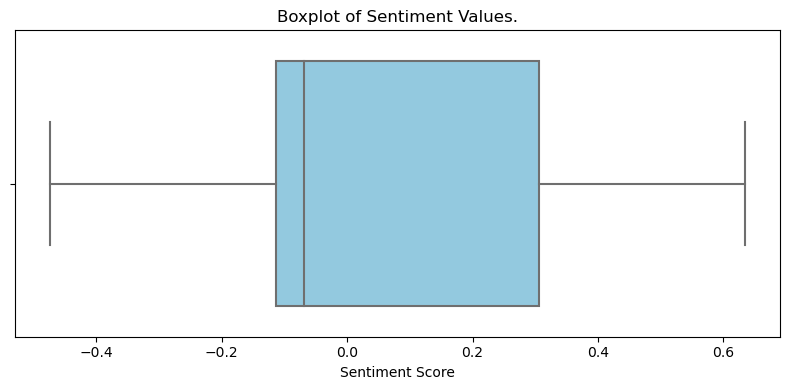

In [6]:
# Removes rows where the (topic) or (stance) is missing and ensures all tweets used have actual content and are labelled.
df.dropna(subset=['topic', 'stance'], inplace=True)
# Drop columns with any missing values
df_cleaned = df.dropna(axis=1)
#Check which columns were actually dropped
dropped_cols = set(df.columns) - set(df_cleaned.columns)
print(f"Dropped columns: {dropped_cols}")

# Remove duplicates
df.drop_duplicates(subset='topic', inplace=True)

# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df.dropna(subset=['created_at'])

# Extract date features
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month		
df['day_of_week'] = df['created_at'].dt.dayofweek  
import pandas as pd

# Ensure 'sentiment' is numeric
df = df[pd.to_numeric(df['sentiment'], errors='coerce').notnull()]
df['sentiment'] = df['sentiment'].astype(float)

# Calculate IQR
Q1 = df['sentiment'].quantile(0.25)
Q3 = df['sentiment'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['sentiment'] < lower_bound) | (df['sentiment'] > upper_bound)]
non_outliers = df[(df['sentiment'] >= lower_bound) & (df['sentiment'] <= upper_bound)]

# Display results
print(f"Number of outliers: {len(outliers)}")
print(f"Number of valid records: {len(non_outliers)}")

# Filter non-outliers
non_outliers = df[(df['sentiment'] >= lower_bound) & (df['sentiment'] <= upper_bound)]

# Plot
plt.figure(figsize=(8, 4))
sns.boxplot(x=non_outliers['sentiment'], color='skyblue')
plt.title('Boxplot of Sentiment Values.')
plt.xlabel('Sentiment Score')
plt.tight_layout()
plt.show()

In [7]:
# Text preprocessing function
nltk.download('stopwords')
def cleaned_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['cleaned_text'] = df['topic'].apply(cleaned_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [8]:
#Encode stance
stance_map = {'deny': -1, 'neutral': 0, 'support': 1}
df['stance_encoded'] = df['stance'].map(stance_map)

# TF-IDF vectorisation
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df['cleaned_text'])

# Labels
y = df['stance_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

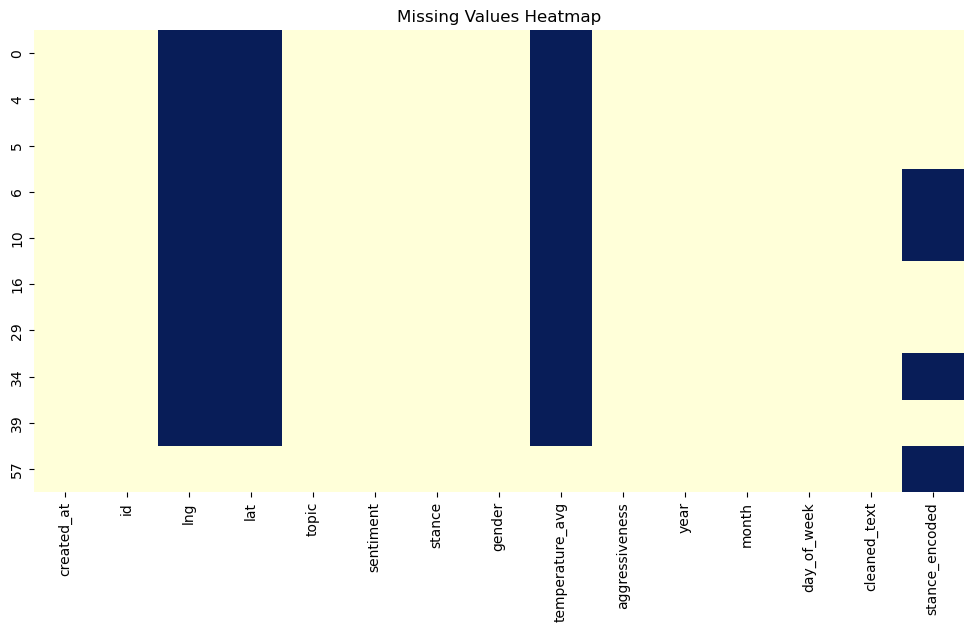

In [9]:
#Missing Values HeatMap
import seaborn as sns
import matplotlib.pyplot as plt

# Visualising missing values after cleaning
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='YlGnBu')
plt.title('Missing Values Heatmap')
plt.show()

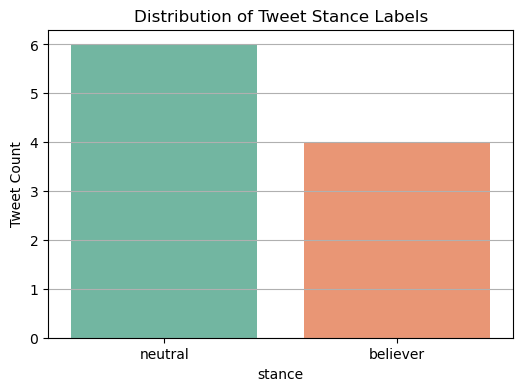

In [10]:
# Stance countplot
plt.figure(figsize=(6,4))
sns.countplot(x='stance', data=df, palette='Set2')
plt.title('Distribution of Tweet Stance Labels')
plt.ylabel('Tweet Count')
plt.grid(axis='y')
plt.show()

In [11]:
df.columns.tolist()

['created_at',
 'id',
 'lng',
 'lat',
 'topic',
 'sentiment',
 'stance',
 'gender',
 'temperature_avg',
 'aggressiveness',
 'year',
 'month',
 'day_of_week',
 'cleaned_text',
 'stance_encoded']

In [12]:
# Create text length and word count features
df['text_length'] = df['cleaned_text'].apply(lambda x: len(str(x)))
df['word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

# Ensure 'aggressiveness' column is numeric to avoid comparison error
df['aggressiveness'] = pd.to_numeric(df['aggressiveness'], errors='coerce')

# Create binary flag for aggressive tweets (1 = aggressive if > 0.5, else 0)
df['is_aggressive'] = df['aggressiveness'].apply(lambda x: 1 if pd.notnull(x) and x > 0.5 else 0)

# Categorize temperature into bands
def temp_band(t):
    try:
        t = float(t)
        if t < 15:
            return 'Cold'
        elif 15 <= t <= 25:
            return 'Mild'
        else:
            return 'Hot'
    except:
        return 'Unknown'

df['temp_band'] = df['temperature_avg'].apply(temp_band)

# Preview enriched features
df[['cleaned_text', 'text_length', 'word_count', 'aggressiveness', 'is_aggressive', 'temperature_avg', 'temp_band']].head()



,cleaned_text,text_length,word_count,aggressiveness,is_aggressive,temperature_avg,temp_band
0,weather extremes,16,2,NaN,0,NaN,Hot
4,importance human intervantion,29,3,NaN,0,NaN,Hot
5,seriousness gas emissions,25,3,NaN,0,NaN,Hot
6,ideological positions global warming,36,4,NaN,0,NaN,Hot
10,impact resource overconsumption,31,3,NaN,0,NaN,Hot


In [13]:
# Ensure datetime is valid
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Standardise gender to lowercase
df['gender'] = df['gender'].str.lower()

# Check for nulls again
print(df.isnull().sum())


created_at          0
id                  0
lng                 9
lat                 9
topic               0
sentiment           0
stance              0
gender              0
temperature_avg     9
aggressiveness     10
year                0
month               0
day_of_week         0
cleaned_text        0
stance_encoded      4
text_length         0
word_count          0
is_aggressive       0
temp_band           0
dtype: int64


In [14]:
df.columns.tolist()


['created_at',
 'id',
 'lng',
 'lat',
 'topic',
 'sentiment',
 'stance',
 'gender',
 'temperature_avg',
 'aggressiveness',
 'year',
 'month',
 'day_of_week',
 'cleaned_text',
 'stance_encoded',
 'text_length',
 'word_count',
 'is_aggressive',
 'temp_band']

In [15]:
final_df = df[[
    'created_at','id','lng','lat',
    'topic','sentiment','stance',
    'gender','temperature_avg','aggressiveness',
    'year','month','day_of_week','cleaned_text',
    'text_length','word_count','is_aggressive','temp_band'
]]

# Preview the final structured data
print("Final dataset shape:", final_df.shape)
final_df.head()

Final dataset shape: (10, 18)


,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness,year,month,day_of_week,cleaned_text,text_length,word_count,is_aggressive,temp_band
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,NaN,2006,6,1,weather extremes,16,2,0,Hot
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,NaN,2006,11,0,importance human intervantion,29,3,0,Hot
5,2006-11-29 23:21:04+00:00,454763,NaN,NaN,Seriousness of Gas Emissions,-0.283467,neutral,male,NaN,NaN,2006,11,2,seriousness gas emissions,25,3,0,Hot
6,2006-12-11 22:08:14+00:00,971753,NaN,NaN,Ideological Positions on Global Warming,-0.046626,believer,male,NaN,NaN,2006,12,0,ideological positions global warming,36,4,0,Hot
10,2006-12-29 22:21:09+00:00,1835943,NaN,NaN,Impact of Resource Overconsumption,0.634859,believer,male,NaN,NaN,2006,12,4,impact resource overconsumption,31,3,0,Hot


In [16]:
final_df.to_csv("cleaned_climate_tweets.csv", index=False)
print("Structured data saved to cleaned_climate_tweets.csv")


Structured data saved to cleaned_climate_tweets.csv


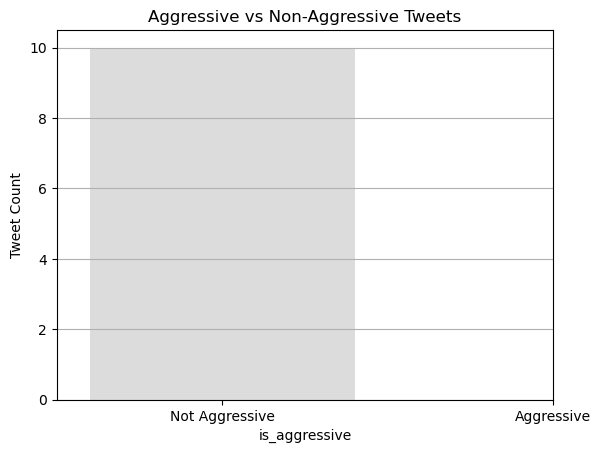

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='is_aggressive', palette='coolwarm')
plt.title('Aggressive vs Non-Aggressive Tweets')
plt.xticks([0, 1], ['Not Aggressive', 'Aggressive'])
plt.ylabel('Tweet Count')
plt.grid(axis='y')
plt.show()


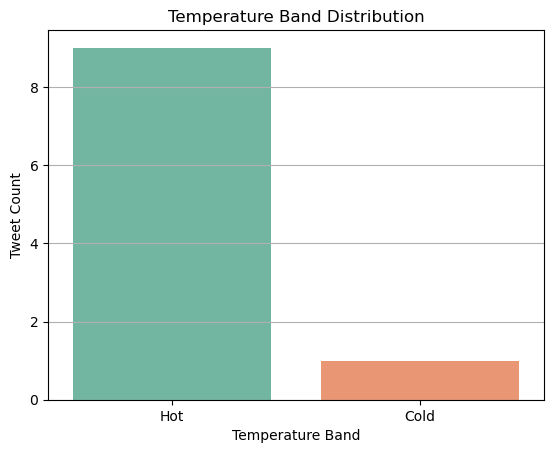

In [18]:
sns.countplot(data=df, x='temp_band', palette='Set2')
plt.title('Temperature Band Distribution')
plt.xlabel('Temperature Band')
plt.ylabel('Tweet Count')
plt.grid(axis='y')
plt.show()


In [19]:
#Perform 
df[['temperature_avg', 'sentiment', 'text_length', 'word_count']].describe()

,temperature_avg,sentiment,text_length,word_count
count,1.000000,10.000000,10.000000,10.000000
mean,2.109439,0.041371,25.100000,3.000000
std,NaN,0.355336,9.949316,1.054093
min,2.109439,-0.474515,8.000000,1.000000
25%,2.109439,-0.113130,18.250000,2.250000
50%,2.109439,-0.068527,27.000000,3.000000
75%,2.109439,0.305254,30.500000,4.000000
max,2.109439,0.634859,39.000000,4.000000


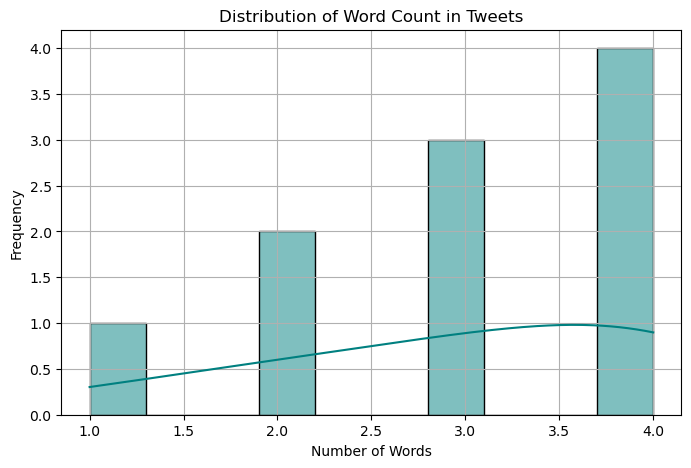

In [20]:
#Histogram of word count
plt.figure(figsize=(8,5))
sns.histplot(df['word_count'].dropna(), bins=10, kde=True, color='teal')
plt.title("Distribution of Word Count in Tweets")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

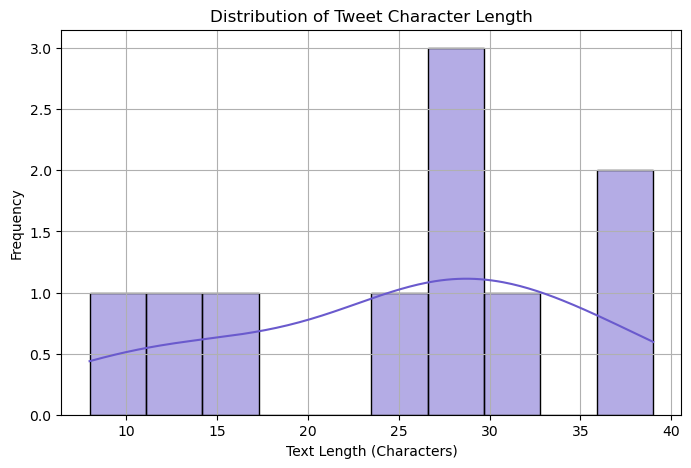

In [21]:
#Histogram of text length
plt.figure(figsize=(8,5))
sns.histplot(df['text_length'].dropna(), bins=10, kde=True, color='slateblue')
plt.title("Distribution of Tweet Character Length")
plt.xlabel("Text Length (Characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

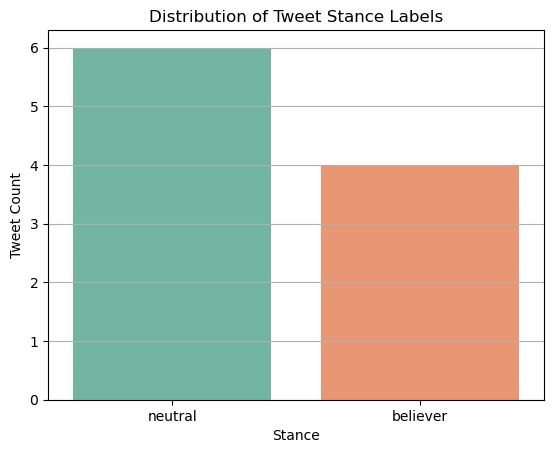

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='stance', palette='Set2')
plt.title('Distribution of Tweet Stance Labels')
plt.ylabel('Tweet Count')
plt.xlabel('Stance')
plt.grid(axis='y')
plt.show()


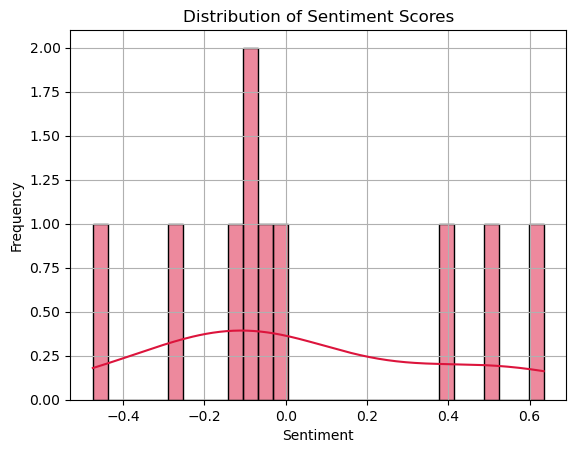

In [23]:
#Histogram showing distribution of sentiment scores
sns.histplot(df['sentiment'], bins=30, kde=True, color='crimson')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

C:\Users\bless\AppData\Local\Temp\ipykernel_8016\4177360218.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['created_at'].dt.to_period('M')


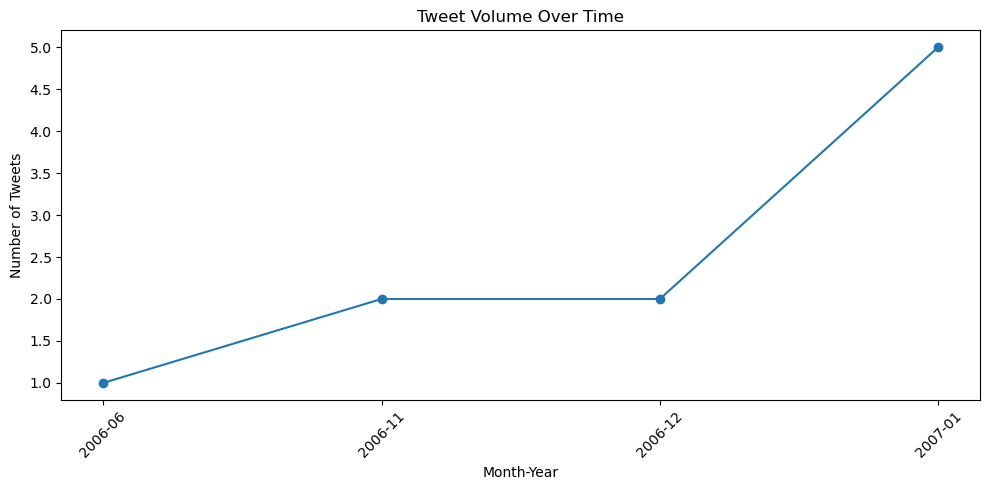

In [24]:
# Ensure 'created_at' is datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Remove rows with invalid or missing dates
df = df.dropna(subset=['created_at'])

# Extract month and year
df['month_year'] = df['created_at'].dt.to_period('M')

# Group and count tweets per month
monthly_counts = df.groupby('month_year').size().reset_index(name='tweet_count')

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_counts['month_year'].astype(str), monthly_counts['tweet_count'], marker='o')
plt.xticks(rotation=45)
plt.title('Tweet Volume Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

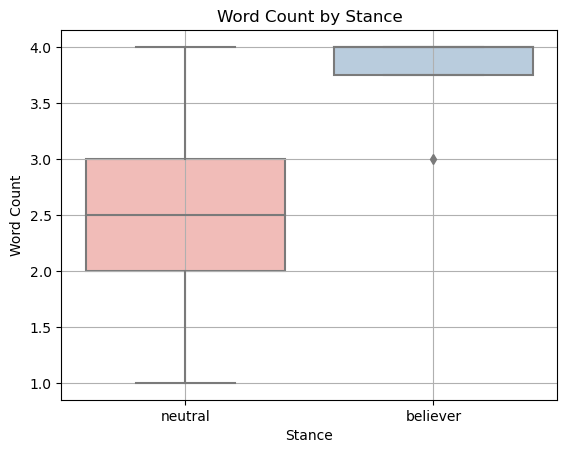

In [25]:
sns.boxplot(data=df, x='stance', y='word_count', palette='Pastel1')
plt.title("Word Count by Stance")
plt.xlabel("Stance")
plt.ylabel("Word Count")
plt.grid(True)
plt.show()

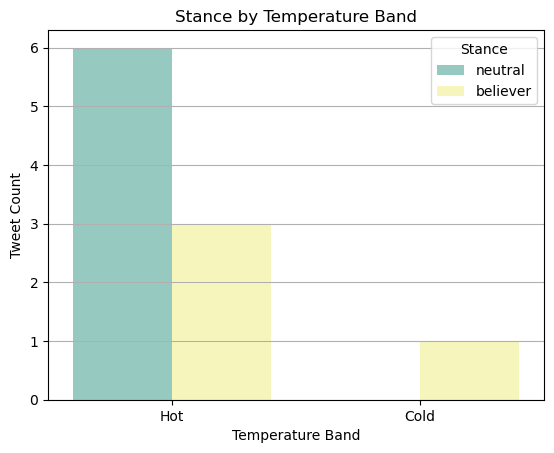

In [26]:
sns.countplot(data=df, x='temp_band', hue='stance', palette='Set3')
plt.title('Stance by Temperature Band')
plt.xlabel('Temperature Band')
plt.ylabel('Tweet Count')
plt.legend(title='Stance')
plt.grid(axis='y')
plt.show()

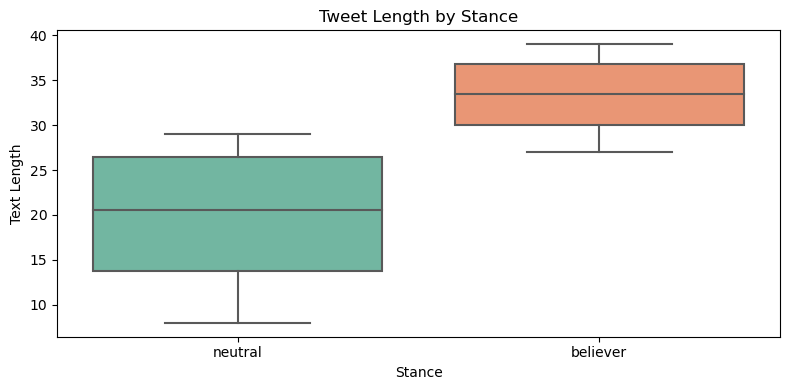

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure relevant columns are present
cols_to_check = ['stance', 'text_length', 'word_count', 'sentiment']
df_compare = df[cols_to_check].dropna()

# Plot 1: Text Length by Stance
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_compare, x='stance', y='text_length', palette='Set2')
plt.title('Tweet Length by Stance')
plt.ylabel('Text Length')
plt.xlabel('Stance')
plt.tight_layout()
plt.show()

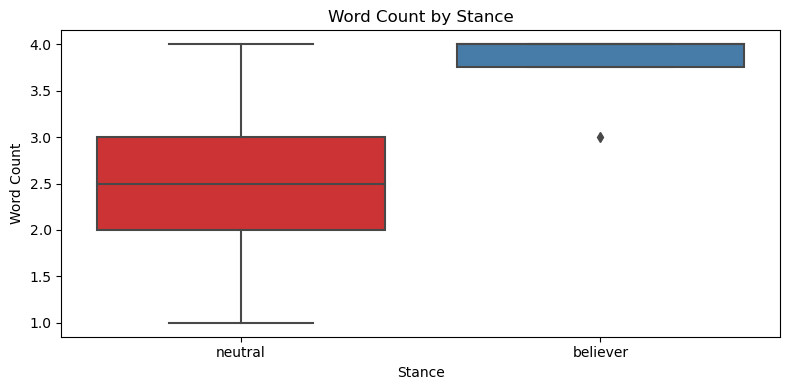

In [28]:
# Plot 2: Word Count by Stance
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_compare, x='stance', y='word_count', palette='Set1')
plt.title('Word Count by Stance')
plt.ylabel('Word Count')
plt.xlabel('Stance')
plt.tight_layout()
plt.show()

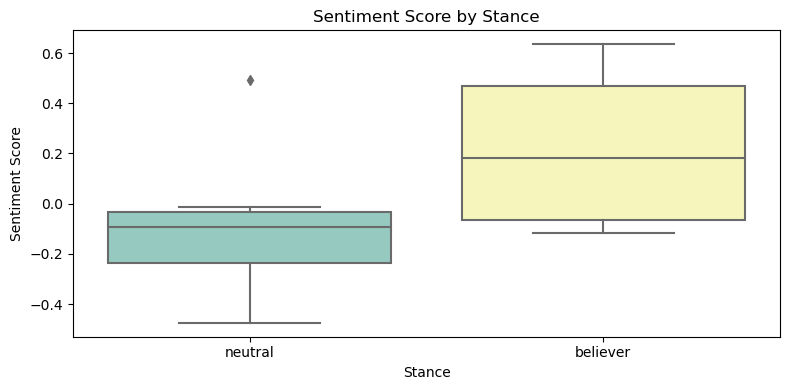

In [29]:
# Plot 3: Sentiment Score by Stance
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_compare, x='stance', y='sentiment', palette='Set3')
plt.title('Sentiment Score by Stance')
plt.ylabel('Sentiment Score')
plt.xlabel('Stance')
plt.tight_layout()
plt.show()

C:\Users\bless\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\bless\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


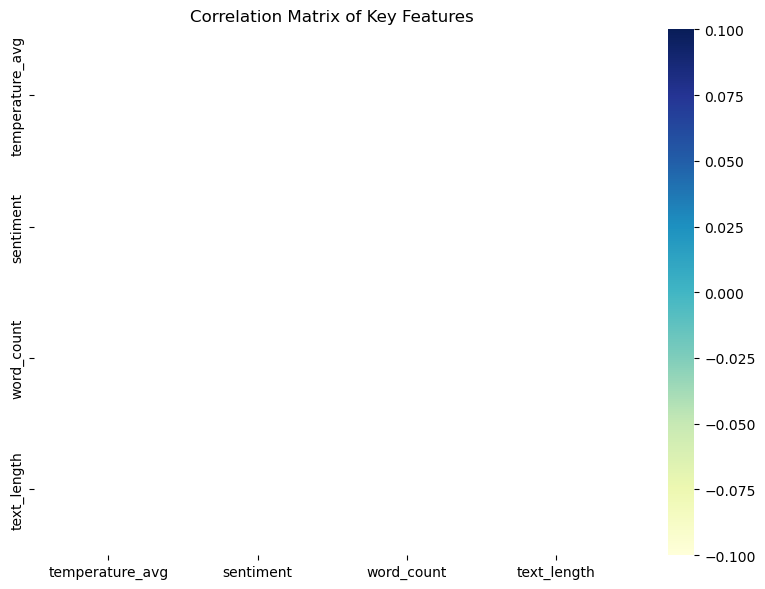

In [30]:
# Drop incomplete rows and plot correlations
df_diag = df.dropna(subset=['temperature_avg', 'sentiment', 'word_count', 'text_length'])
corr_cols = ['temperature_avg', 'sentiment', 'word_count', 'text_length']
corr_matrix = df_diag[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Matrix of Key Features")
plt.tight_layout()
plt.show()


C:\Users\bless\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\bless\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\bless\anaconda3\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


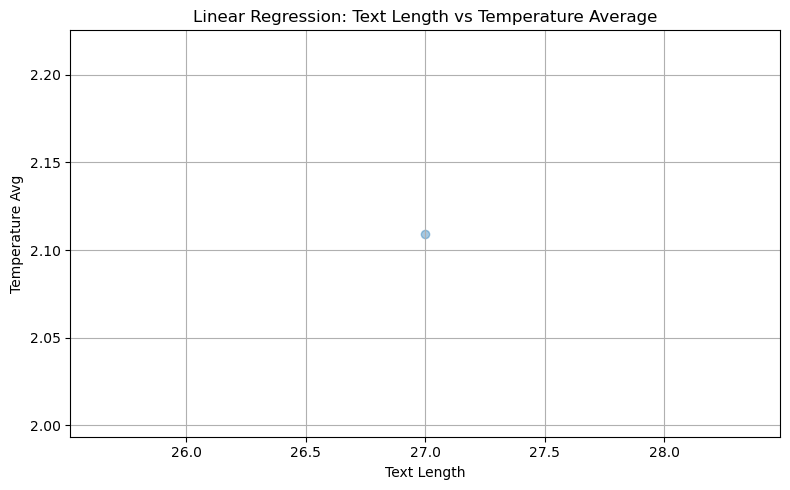

count     1.0
mean     27.0
std       NaN
min      27.0
25%      27.0
50%      27.0
75%      27.0
max      27.0
Name: text_length, dtype: float64
count    1.000000
mean     2.109439
std           NaN
min      2.109439
25%      2.109439
50%      2.109439
75%      2.109439
max      2.109439
Name: temperature_avg, dtype: float64


In [31]:
from scipy.stats import linregress

x = df_diag['text_length']
y = df_diag['temperature_avg']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Visualise regression
plt.figure(figsize=(8,5))
sns.regplot(x=x, y=y, scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title('Linear Regression: Text Length vs Temperature Average')
plt.xlabel('Text Length')
plt.ylabel('Temperature Avg')
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression outputs (interpret in markdown)
(slope, intercept, r_value**2, p_value)
print(x.describe())
print(y.describe())

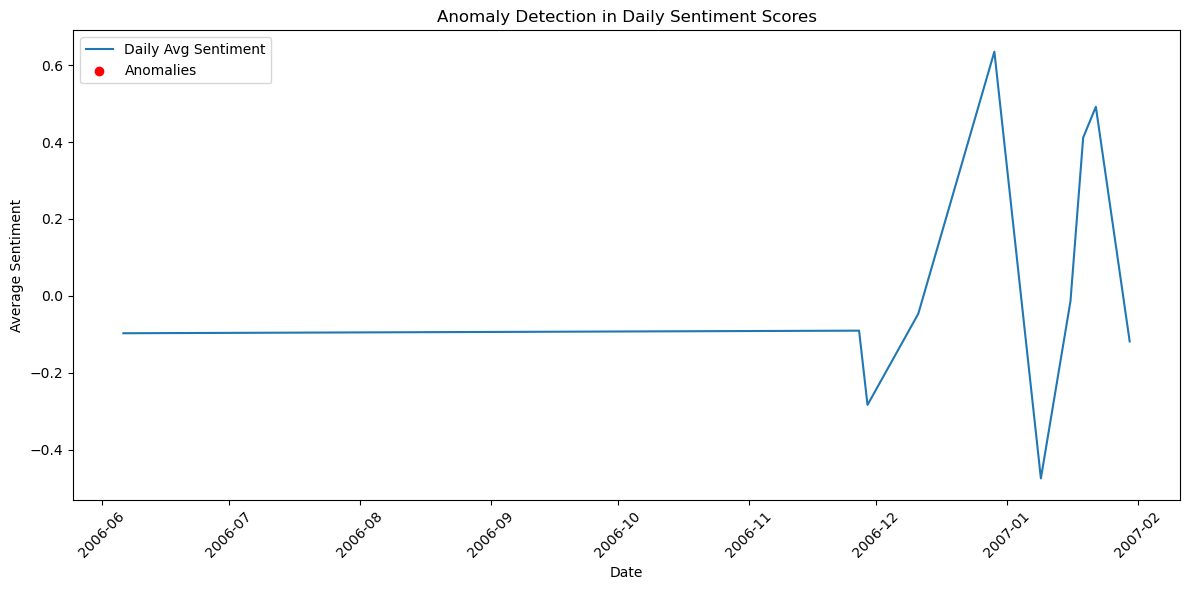

In [32]:
from scipy.stats import zscore

# Aggregate sentiment by day
df['date'] = df['created_at'].dt.date
daily_sentiment = df.groupby('date')['sentiment'].mean().reset_index()

# Compute Z-score
daily_sentiment['z_score'] = zscore(daily_sentiment['sentiment'])

# Identify anomalies (Z-score > 2 or < -2)
anomalies = daily_sentiment[(daily_sentiment['z_score'] > 2) | (daily_sentiment['z_score'] < -2)]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment'], label='Daily Avg Sentiment')
plt.scatter(anomalies['date'], anomalies['sentiment'], color='red', label='Anomalies')
plt.title('Anomaly Detection in Daily Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [33]:
df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness,...,month,day_of_week,cleaned_text,stance_encoded,text_length,word_count,is_aggressive,temp_band,month_year,date
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,NaN,...,6,1,weather extremes,0.0,16,2,0,Hot,2006-06,2006-06-06
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,NaN,...,11,0,importance human intervantion,0.0,29,3,0,Hot,2006-11,2006-11-27
5,2006-11-29 23:21:04+00:00,454763,NaN,NaN,Seriousness of Gas Emissions,-0.283467,neutral,male,NaN,NaN,...,11,2,seriousness gas emissions,0.0,25,3,0,Hot,2006-11,2006-11-29
6,2006-12-11 22:08:14+00:00,971753,NaN,NaN,Ideological Positions on Global Warming,-0.046626,believer,male,NaN,NaN,...,12,0,ideological positions global warming,NaN,36,4,0,Hot,2006-12,2006-12-11
10,2006-12-29 22:21:09+00:00,1835943,NaN,NaN,Impact of Resource Overconsumption,0.634859,believer,male,NaN,NaN,...,12,4,impact resource overconsumption,NaN,31,3,0,Hot,2006-12,2006-12-29


In [34]:
# Preprocessing: Handle missing values
# For numerical columns, use the mean to fill missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df['temperature_avg'] = imputer.fit_transform(df[['temperature_avg']])

# Encode categorical variables (e.g., 'gender' and 'stance')
label_encoder = LabelEncoder()
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])
df['stance_encoded'] = label_encoder.fit_transform(df['stance'])

# Now we split the dataset into features (X) and target (y)
X = df.drop(['sentiment', 'created_at', 'id', 'stance', 'gender'], axis=1)  # Drop non-feature columns
y = df['sentiment']  # Target column is 'sentiment'

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [35]:

X = df.drop(['stance', 'gender', 'created_at', 'id', 'topic'], axis=1)  # keep only numeric columns


print(X.dtypes)


lng                  float64
lat                  float64
sentiment            float64
temperature_avg      float64
aggressiveness       float64
year                   int64
month                  int64
day_of_week            int64
cleaned_text          object
stance_encoded         int32
text_length            int64
word_count             int64
is_aggressive          int64
temp_band             object
month_year         period[M]
date                  object
gender_encoded         int32
dtype: object


In [36]:
from sklearn.preprocessing import LabelEncoder

le_band = LabelEncoder()
df['temp_band_encoded'] = le_band.fit_transform(df['temp_band'])




In [37]:
X = df.drop(['cleaned_text', 'temp_band', 'stance', 'gender', 'created_at', 'id'], axis=1)


In [38]:
print(X.dtypes)


lng                    float64
lat                    float64
topic                   object
sentiment              float64
temperature_avg        float64
aggressiveness         float64
year                     int64
month                    int64
day_of_week              int64
stance_encoded           int32
text_length              int64
word_count               int64
is_aggressive            int64
month_year           period[M]
date                    object
gender_encoded           int32
temp_band_encoded        int32
dtype: object


In [39]:
#Question 5: Predictive Analytics - Modelling the Data
#Load Libraries
# SECTION B5 - Step 1: Load Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score



In [40]:
#Step 2: Encode target and check class balance
df['stance_encoded'] = LabelEncoder().fit_transform(df['stance'])

#Visualise class distribution before training
print("Class distribution in full dataset:")
print(df['stance_encoded'].value_counts())


Class distribution in full dataset:
1    6
0    4
Name: stance_encoded, dtype: int64


In [41]:
#Step 3: Convert cleaned_text into TF-IDF features
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(df['cleaned_text'].fillna("")).toarray()
#Step 4: Select structured numerical features only
numeric_features = [
    'lng', 'lat', 'temperature_avg', 'aggressiveness',
    'year', 'month', 'day_of_week', 'text_length', 'word_count',
    'is_aggressive', 'gender_encoded', 'temp_band_encoded'
]
X_structured = df[numeric_features].fillna(0)
#Step 5: Combine structured and text-based features
X_combined = np.concatenate((X_structured.values, X_text), axis=1)
y = df['stance_encoded']




In [42]:
# Step 6: Perform stratified train-test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

In [43]:
# Step 7: Train the models
# TRAIN MULTIPLE CLASSIFIERS 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": LinearSVC()
}

# Train and evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Print all results
for name, res in results.items():
    print(f"\n===== {name} =====")
    print("Accuracy:", res["Accuracy"])
    print("Classification Report:\n", res["Classification Report"])
    print("Confusion Matrix:\n", res["Confusion Matrix"])


===== Random Forest =====
Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

Confusion Matrix:
 [[0 1]
 [0 2]]

===== Logistic Regression =====
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion Matrix:
 [[1 0]
 [0 2]]

===== Naive Bayes =====
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         

C:\Users\bless\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bless\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bless\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bless\anaconda3\Lib\site-packages\sklearn\svm\

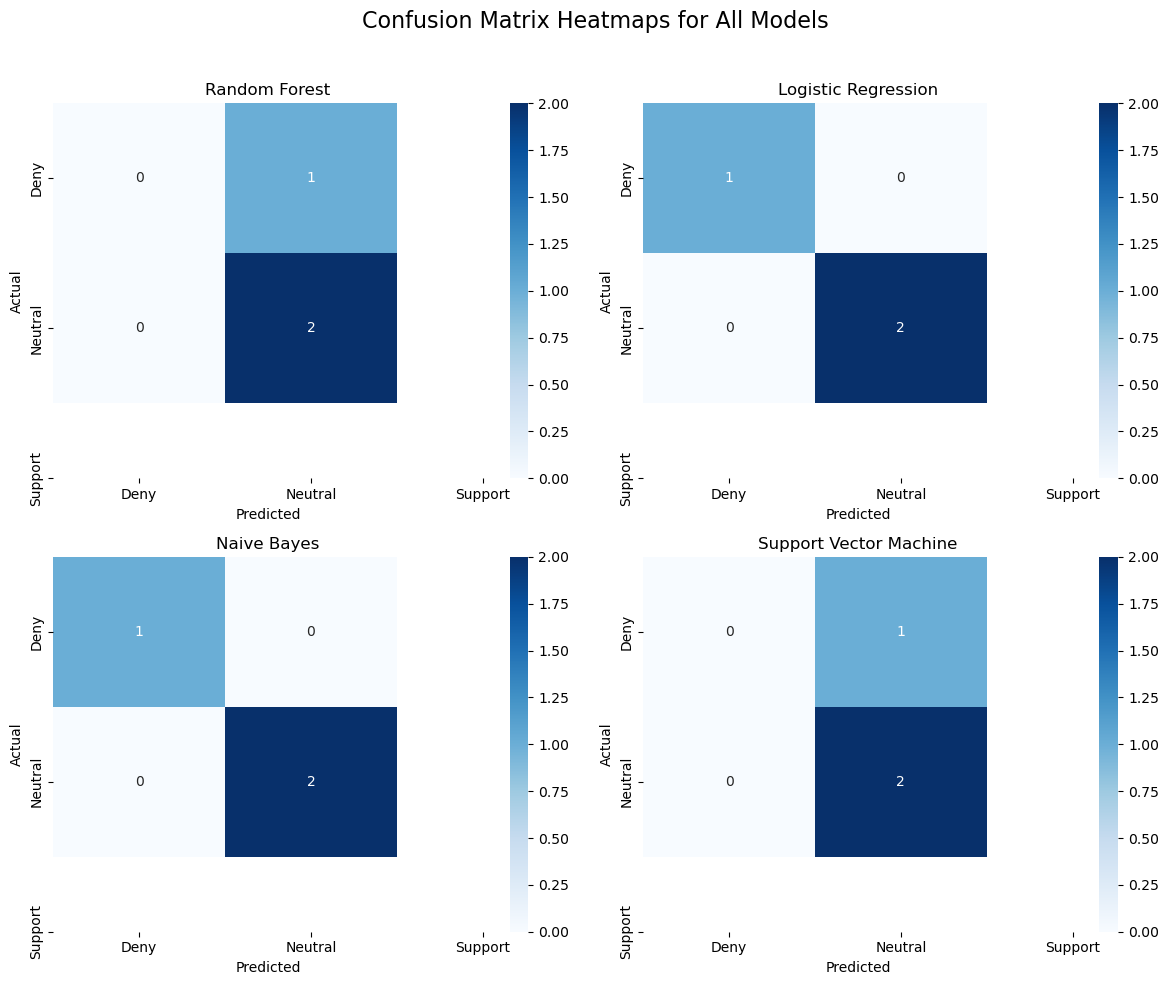

In [44]:
#Step 8: VIew COnfusion Matrix of all Models for comparison
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define class labels (adjust if needed)
labels = ['Deny', 'Neutral', 'Support']

# Create a subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Confusion Matrix Heatmaps for All Models', fontsize=16)

# Define model names and axes positions
model_keys = ["Random Forest", "Logistic Regression", "Naive Bayes", "Support Vector Machine"]
positions = [(0,0), (0,1), (1,0), (1,1)]

for model_name, pos in zip(model_keys, positions):
    y_pred = models[model_name].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[pos]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # adjust layout to fit suptitle
plt.show()



In [45]:
# Plot feature importances (only for structured features)
importances = clf.feature_importances_[:len(X_structured.columns)]
feature_names = X_structured.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance (Structured Features)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


NameError: name 'clf' is not defined

In [ ]:
# KMEANS CLUSTERING ON STRUCTURED FEATURES ONLY 
from sklearn.cluster import KMeans
# Define structured features for clustering 
X_meta = df[['sentiment', 'word_count', 'temperature_avg', 'text_length']].dropna()
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_meta)

# CLUSTER VISUALISATION 
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['word_count'], y=df['sentiment'], hue=clusters, palette='Set2')
plt.title('KMeans Clustering by Word Count and Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Sentiment')
plt.tight_layout()
plt.show()
